# EuroSAT Dataset Applying Custom CNN + GCNet Attention Module + ML Classifiers

In [19]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [20]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [21]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [22]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


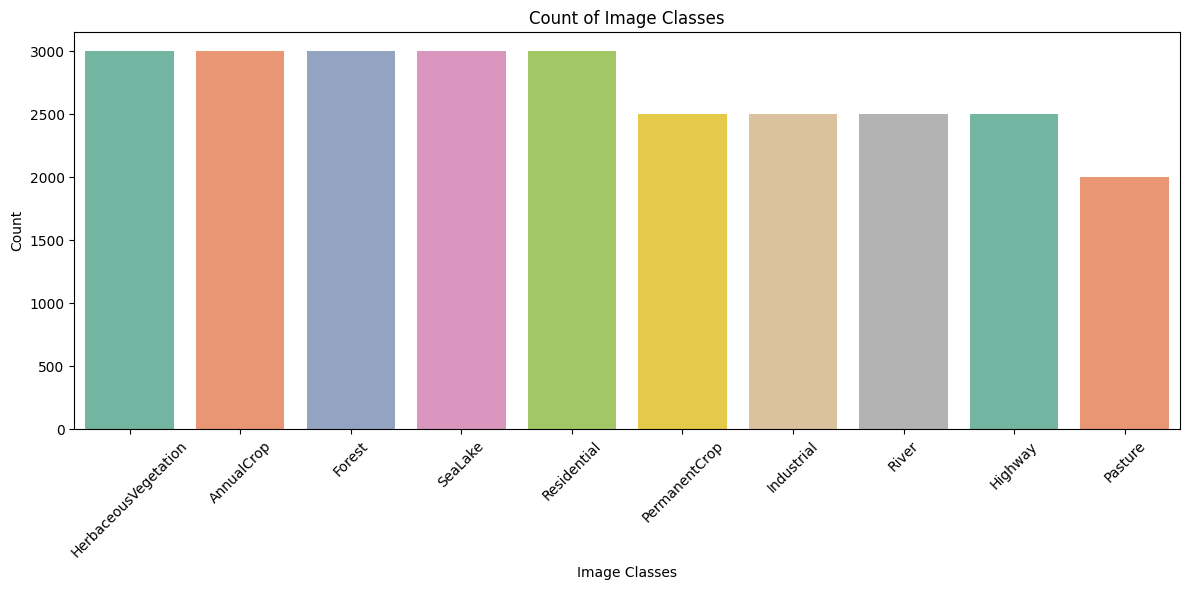

In [23]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

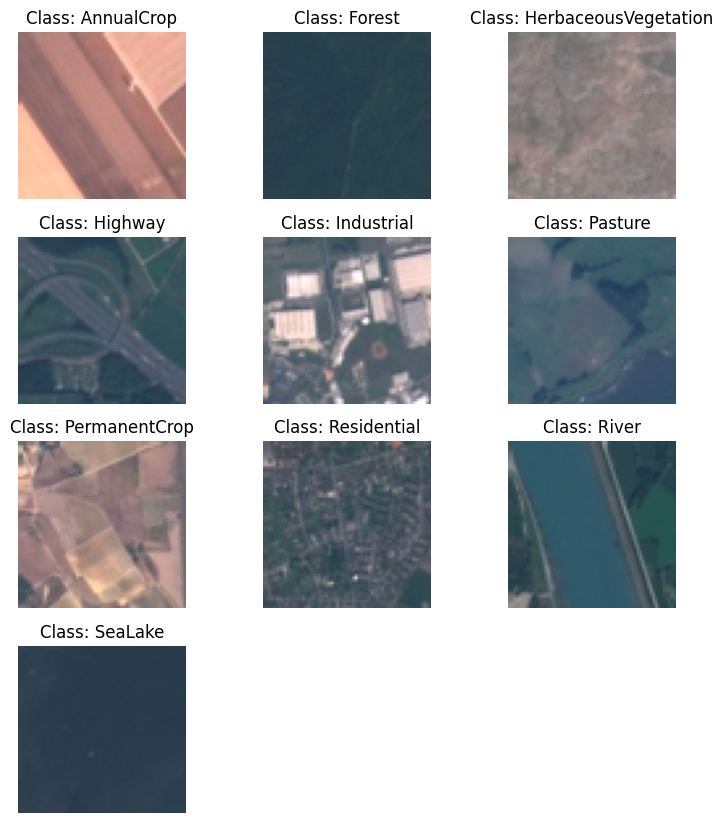

In [24]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [25]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [26]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [27]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [28]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [30]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [31]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [32]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [33]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [34]:
class GCBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(GCBlock, self).__init__()
        self.conv_mask = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.softmax = nn.Softmax(dim=2)

        self.transform = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.LayerNorm([in_channels // reduction, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        )

    def forward(self, x):
        batch, c, h, w = x.size()

        # [B, 1, H, W] → [B, 1, H*W]
        context_mask = self.conv_mask(x).view(batch, 1, -1)
        context_mask = self.softmax(context_mask)  # [B, 1, H*W]

        # [B, C, H*W]
        x_reshaped = x.view(batch, c, -1)

        # Global context vector: [B, C, 1]
        context = torch.bmm(x_reshaped, context_mask.transpose(1, 2))  # [B, C, 1]
        context = context.unsqueeze(-1)  # [B, C, 1, 1]

        # Transform and add
        out = self.transform(context)  # [B, C, 1, 1]
        return x + out  # residual connection

### Convolutional Neural Netwirk (G7CNN)

In [35]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56

            # Block 3
            nn.Conv2d(64, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 84 x 28 x 28
            GCBlock(84),

            # Block 4
            nn.Conv2d(84, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 14 x 14
            GCBlock(128),

            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 7 x 7
            GCBlock(256),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 256 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 256
            nn.Linear(256, 256),                 # → 256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [36]:

checkpoint = torch.load('/kaggle/input/cnn-gcnet-attention/pytorch/default/1/model-gcnet.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_weight', 'optimizer_state'])


In [37]:

total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)
model = model.to(device)
model.load_state_dict(checkpoint['model_weight'],strict=False)
model.eval()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# summary(model, input_size=(3, 224, 224))



G7CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### Extracting Feature

In [38]:

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels


features, labels = extract_features(model, dataloader_test_dataset, device)

Extracting features: 100%|██████████| 507/507 [00:08<00:00, 63.31it/s]


### Train-Test Spliting

In [39]:

X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

### Training

In [40]:

# Initialize classifiers
initialized_models = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=1),
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [41]:

# Evaluation each classifiers
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()

    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results = {
        'model_name': name,
        'model': model,
        'y_true': y_test,
        'y_pred': y_pred,
        'classification_report': report,
        'confusion_matrix': cm,
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': end_train - start_train,
        'testing_time': end_test - start_test
    }

    return results

results_dict = {}
for name, clf in tqdm(initialized_models.items(), desc="Training:", total=len(initialized_models)):
        results_dict[name] = evaluate_model(name, clf, X_train, y_train, X_test, y_test)

Training:: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


### Evaluation

In [42]:

for name, result in results_dict.items():
    print(f"\n{name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Training time: {result['training_time']:.2f}s")
    print(f"Testing time: {result['testing_time']:.2f}s")


SVM
Accuracy: 0.9827
Training time: 0.18s
Testing time: 0.02s

KNN
Accuracy: 0.9802
Training time: 0.01s
Testing time: 0.04s

RandomForest
Accuracy: 0.9864
Training time: 0.68s
Testing time: 0.03s

XGBoost
Accuracy: 0.9840
Training time: 0.34s
Testing time: 0.01s


In [43]:

import joblib
# Save all models
joblib.dump({name: result['model'] for name, result in results_dict.items()}, '/kaggle/working/ml-classifiers-models.pkl')

# Load all models later
# loaded_models = joblib.load('all_models.pkl')
# y_pred = loaded_models['RandomForest'].predict(X_test)

['/kaggle/working/ml-classifiers-models.pkl']

### Classification Report

In [44]:

from collections import defaultdict

def class_accuracy_sklearn(model, features, labels, num_classes):
    preds = model.predict(features)
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for true, pred in zip(labels, preds):
        class_total[true] += 1
        if true == pred:
            class_correct[true] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

In [45]:

for name, result in results_dict.items():
    print(f"\nClassification report: {name}")
    print(classification_report(result['y_true'], result['y_pred']))

    class_acc = class_accuracy_sklearn(result['model'], features, labels, 10)
    for i, acc in enumerate(class_acc):
        print(f"Class {i}: {acc:.2%}")



Classification report: SVM
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        90
           1       1.00      0.99      0.99        90
           2       0.98      0.99      0.98        90
           3       0.99      1.00      0.99        75
           4       1.00      0.99      0.99        75
           5       0.95      1.00      0.98        60
           6       0.96      0.97      0.97        75
           7       1.00      0.99      0.99        90
           8       0.97      0.96      0.97        75
           9       0.99      1.00      0.99        90

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810

Class 0: 96.44%
Class 1: 99.56%
Class 2: 97.11%
Class 3: 98.93%
Class 4: 99.47%
Class 5: 98.00%
Class 6: 97.33%
Class 7: 99.11%
Class 8: 97.33%
Class 9: 99.56%

Classification report: KNN
              precision  

### Confusion Matrix


SVM


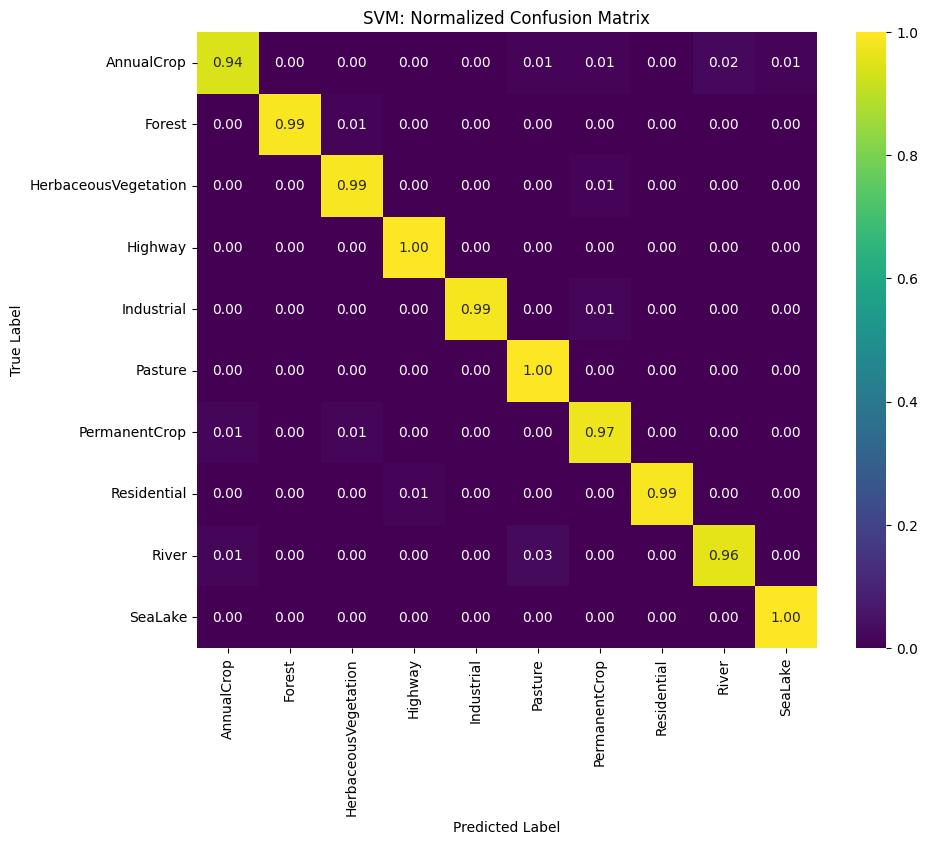


KNN


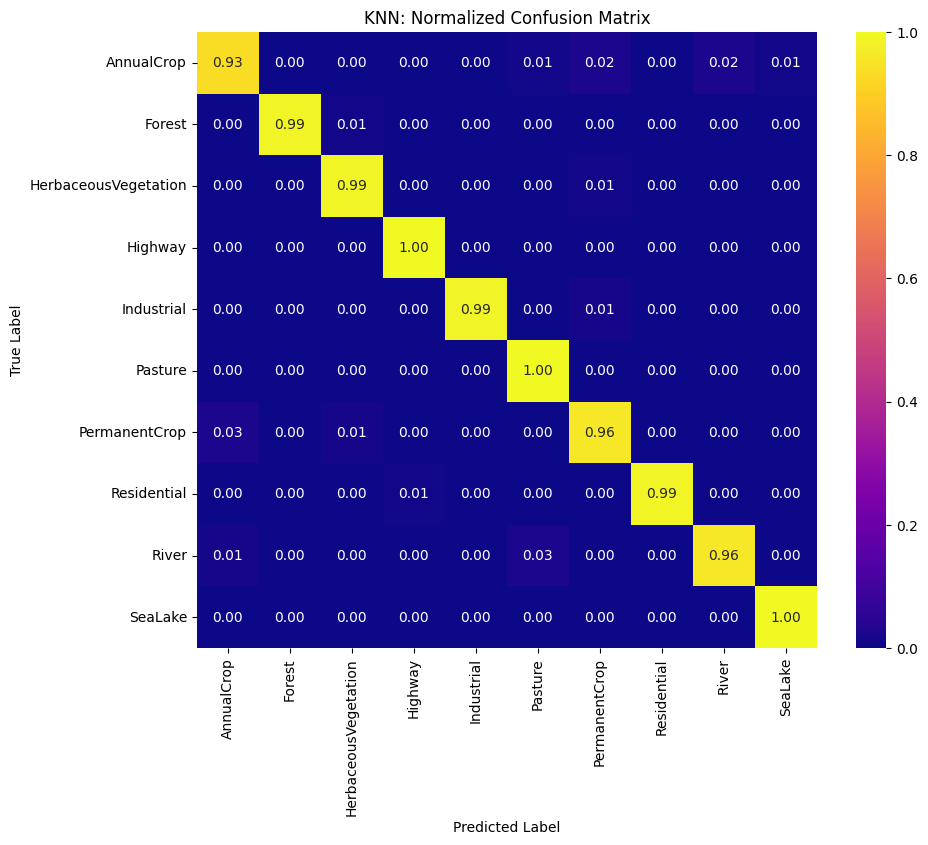


RandomForest


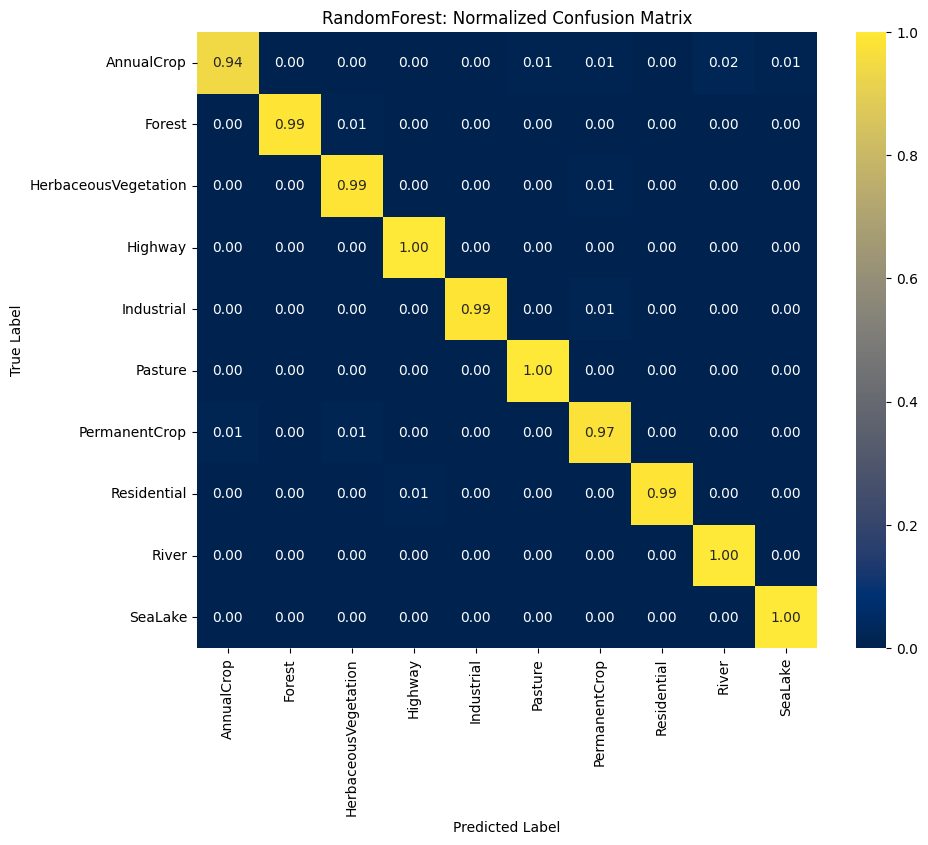


XGBoost


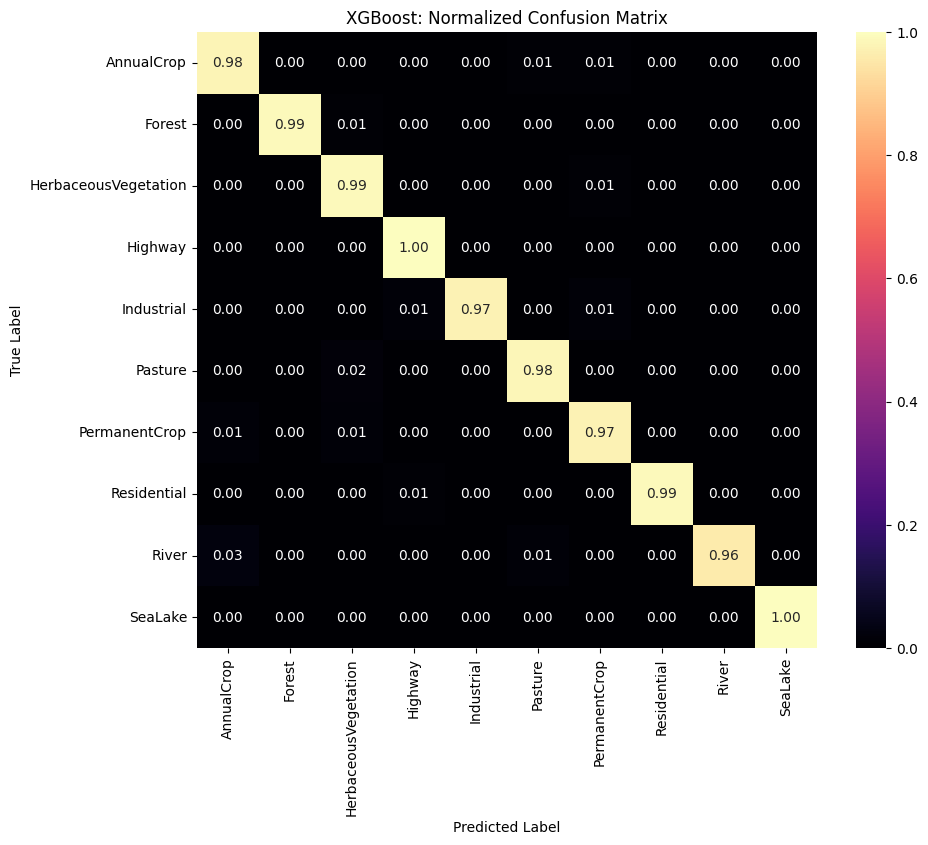

In [46]:

cmaps = ['viridis', 'plasma', 'cividis', 'magma']
for i, (name, result) in enumerate(results_dict.items()):
    print(f"\n{name}")
    cm = result['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap_choice = cmaps[i % len(cmaps)] 
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap_choice, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name}: Normalized Confusion Matrix')
    plt.show()

### AUC, ROC Curve

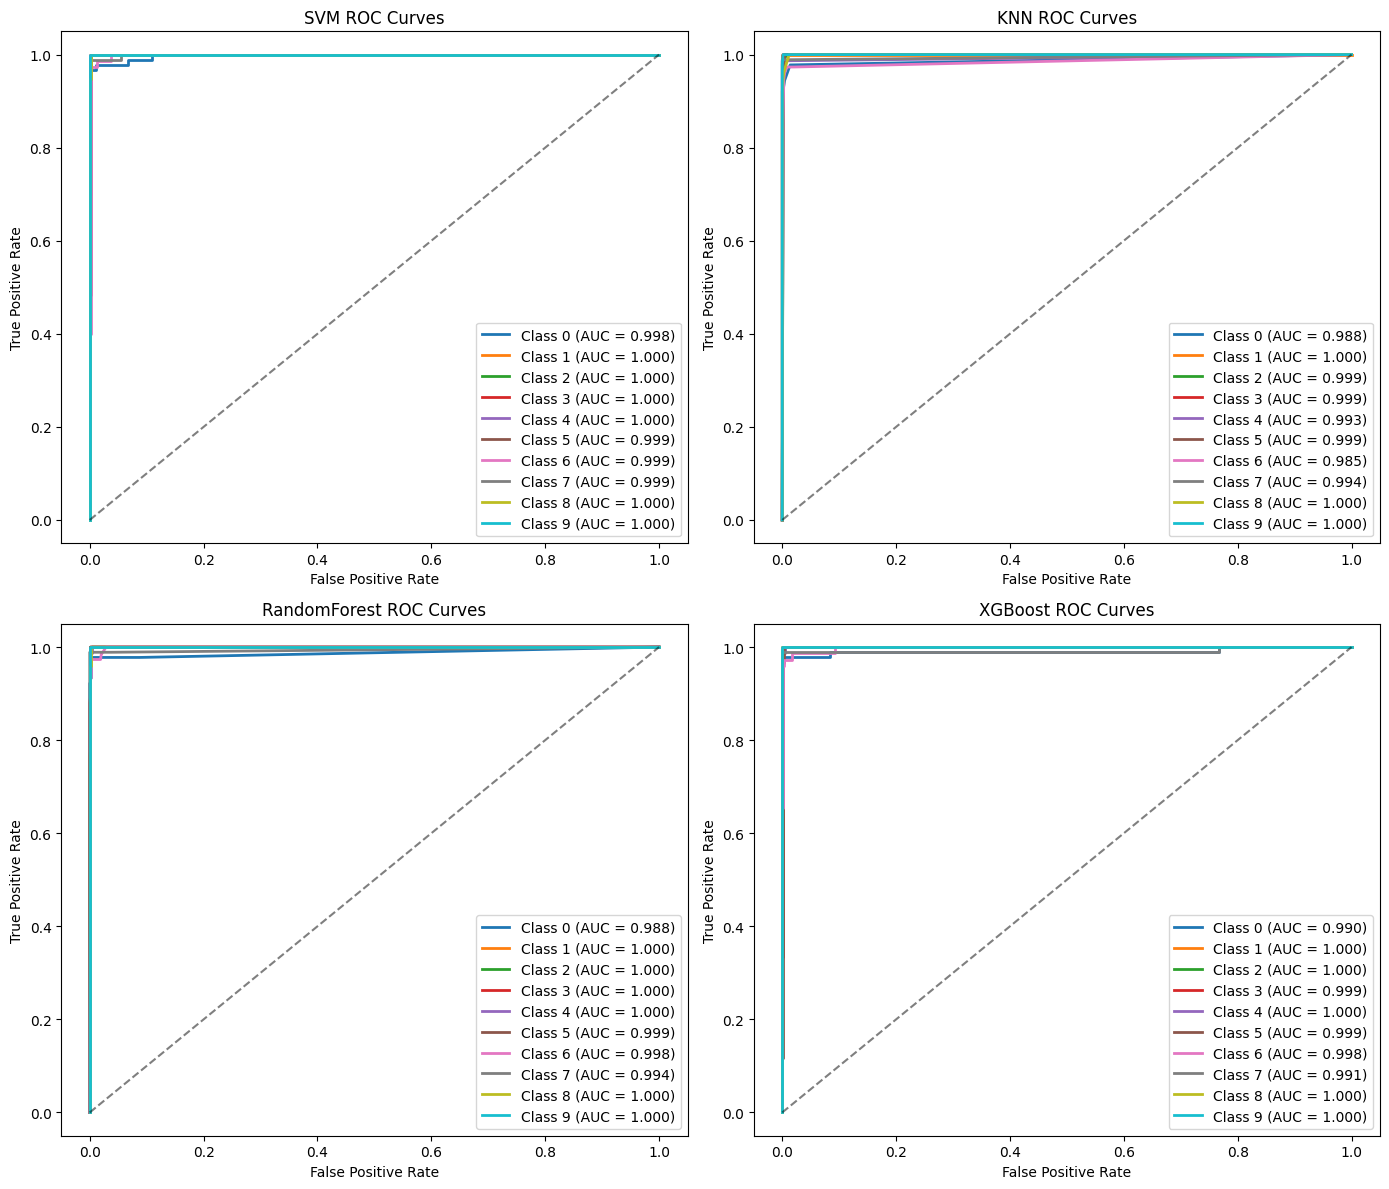

In [47]:

# Binarize the labels for multi-class ROC
num_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(num_classes))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results_dict.items()):
    model = result['model']
    
    # Get probability predictions
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # For models that don't have predict_proba (just in case)
        continue

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    ax = axes[idx]
    for i in range(num_classes):
        ax.plot(fpr[i], tpr[i],lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.3f})")
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_title(f"{name} ROC Curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()
